## Understanding Eigenvector Centrality in Networks

This notebook demonstrates how eigenvector centrality works, implements it from scratch using matrix operations, and explores cases where it behaves unexpectedly in directed graphs.

### Learning Objectives

- Understand the mathematical definition and intuition behind eigenvector centrality
- Learn how to implement the power iteration method for computing eigenvector centrality
- Visualize eigenvector centrality in network structures
- Understand why eigenvector centrality fails in Directed Acyclic Graphs (DAGs)
- Learn about alternative centrality measures for DAGs

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

## 1. What is Eigenvector Centrality?

Eigenvector centrality is a measure of influence of a node in a network based on the concept that:
- Connections to high-scoring nodes contribute more to a node's score than connections to low-scoring nodes
- A node is important if it is connected to other important nodes

### Mathematical Definition

If x is the centrality vector and A is the adjacency matrix, eigenvector centrality is defined by:

$$\lambda x = Ax$$

Where:
- $\lambda$ is the largest eigenvalue of A
- $x$ is the corresponding eigenvector

### Intuitive Meaning

- **Regular degree centrality** answers: "How many connections does this node have?"
- **Eigenvector centrality** answers: "How connected is this node to other well-connected nodes?"

This introduces a recursive element - a node's importance depends on the importance of its neighbors. This makes eigenvector centrality particularly useful for identifying influential nodes in social networks, citation networks, and web page ranking algorithms.

### Real-World Applications

- **Social network influence analysis**: Identifying key influencers in social graphs
- **Recommender systems**: Finding important items in user-item interaction networks
- **Disease spread**: Identifying potential super-spreaders in contact networks

In [2]:
def compute_eigenvector_centrality(adjacency_matrix, max_iterations=100, tolerance=1e-6):
    """
    Compute eigenvector centrality from scratch using the power iteration method.
    
    Parameters:
    -----------
    adjacency_matrix : numpy.ndarray
        The adjacency matrix of the graph.
    max_iterations : int
        Maximum number of iterations for the power method.
    tolerance : float
        Convergence threshold for the power method.
    
    Returns:
    --------
    numpy.ndarray
        Normalized eigenvector centrality scores.
    """
    n = adjacency_matrix.shape[0]
    # Initialize centrality vector with equal probability distribution
    x = np.full(n, 1.0 / n)
    
    for i in range(max_iterations):
        # Compute the new centrality vector
        x_new = adjacency_matrix @ x
        norm = np.linalg.norm(x_new)
        
        # If norm is zero, normalization cannot be performed
        if norm == 0:
            print("Warning: Zero centrality vector detected. This often occurs in DAGs.")
            return x_new
        
        # Normalize the updated vector
        x_new /= norm
        
        # Check for relative convergence
        if np.linalg.norm(x_new - x) / np.linalg.norm(x_new) < tolerance:
            print(f"Converged after {i+1} iterations")
            return x_new
        
        # Update vector for the next iteration
        x = x_new
        
    print(f"Warning: Did not converge after {max_iterations} iterations")
    return x


## 2. Power Iteration Method Explanation

The above implementation uses the power iteration method to find the eigenvector corresponding to the largest eigenvalue:

### Algorithm Steps:

1. **Initialization**: Start with a uniform vector (all values = 1/n)
2. **Iteration**: Repeatedly multiply the adjacency matrix by the current vector
3. **Normalization**: After each multiplication, normalize the vector to prevent overflow
4. **Convergence**: Stop when the vector stops changing significantly

### Mathematical Foundation:

Any vector $v$ can be written as a linear combination of the eigenvectors of matrix $A$:

$$v = c_1v_1 + c_2v_2 + ... + c_nv_n$$

When repeatedly multiplied by $A$:

$$A^k v = c_1\lambda_1^k v_1 + c_2\lambda_2^k v_2 + ... + c_n\lambda_n^k v_n$$

If $\lambda_1$ is the largest eigenvalue, then as $k$ increases, the term $c_1\lambda_1^k v_1$ will dominate, and the result will converge to a multiple of $v_1$ (the principal eigenvector).

> **Why it works**: Under repeated multiplication by A, any initial vector will eventually align with the principal eigenvector of A, as components along other eigenvectors decay faster.

In [3]:
# Let's create an undirected graph example
G_undirected = nx.Graph()
G_undirected.add_edges_from([
    (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (4, 6), (5, 6)
])

# Convert to adjacency matrix
A_undirected = nx.adjacency_matrix(G_undirected).toarray()

print("Adjacency matrix of the undirected graph:")
print(A_undirected)

# Compute eigenvector centrality
our_centrality = compute_eigenvector_centrality(A_undirected)

# Compare with NetworkX's implementation
nx_centrality = nx.eigenvector_centrality(G_undirected)
nx_centrality_values = np.array([nx_centrality[i] for i in range(len(G_undirected))])

# Print results
print("\nOur implementation:")
for i, c in enumerate(our_centrality):
    print(f"Node {i}: {c:.6f}")
    
print("\nNetworkX implementation:")
for i, c in enumerate(nx_centrality_values):
    print(f"Node {i}: {c:.6f}")

# Check how similar our implementation is to NetworkX's
# (Note: signs might be flipped but absolute values should match)
similarity = abs(np.dot(our_centrality, nx_centrality_values) / 
             (np.linalg.norm(our_centrality) * np.linalg.norm(nx_centrality_values)))
print(f"\nCosine similarity between implementations: {similarity:.6f}")

Adjacency matrix of the undirected graph:
[[0 1 1 0 0 0 0]
 [1 0 1 1 0 0 0]
 [1 1 0 1 0 0 0]
 [0 1 1 0 1 0 0]
 [0 0 0 1 0 1 1]
 [0 0 0 0 1 0 1]
 [0 0 0 0 1 1 0]]
Converged after 39 iterations

Our implementation:
Node 0: 0.362002
Node 1: 0.490382
Node 2: 0.490382
Node 3: 0.476196
Node 4: 0.309383
Node 5: 0.181003
Node 6: 0.181003

NetworkX implementation:
Node 0: 0.362000
Node 1: 0.490380
Node 2: 0.490380
Node 3: 0.476196
Node 4: 0.309387
Node 5: 0.181008
Node 6: 0.181008

Cosine similarity between implementations: 1.000000


## 3. Visualizing Eigenvector Centrality in an Undirected Graph

In the visualization below:
- Each node's size represents its eigenvector centrality
- Notice how nodes in the center of the network tend to have higher centrality
- This makes intuitive sense because centrality measures influence

### Interpretation of Results:

- **High centrality nodes**: These are well-connected to other important nodes and represent key points of influence in the network
- **Low centrality nodes**: These are peripheral nodes or nodes connected primarily to other non-central nodes

In many real-world applications, resources or attention would be allocated to the high centrality nodes for maximum impact.

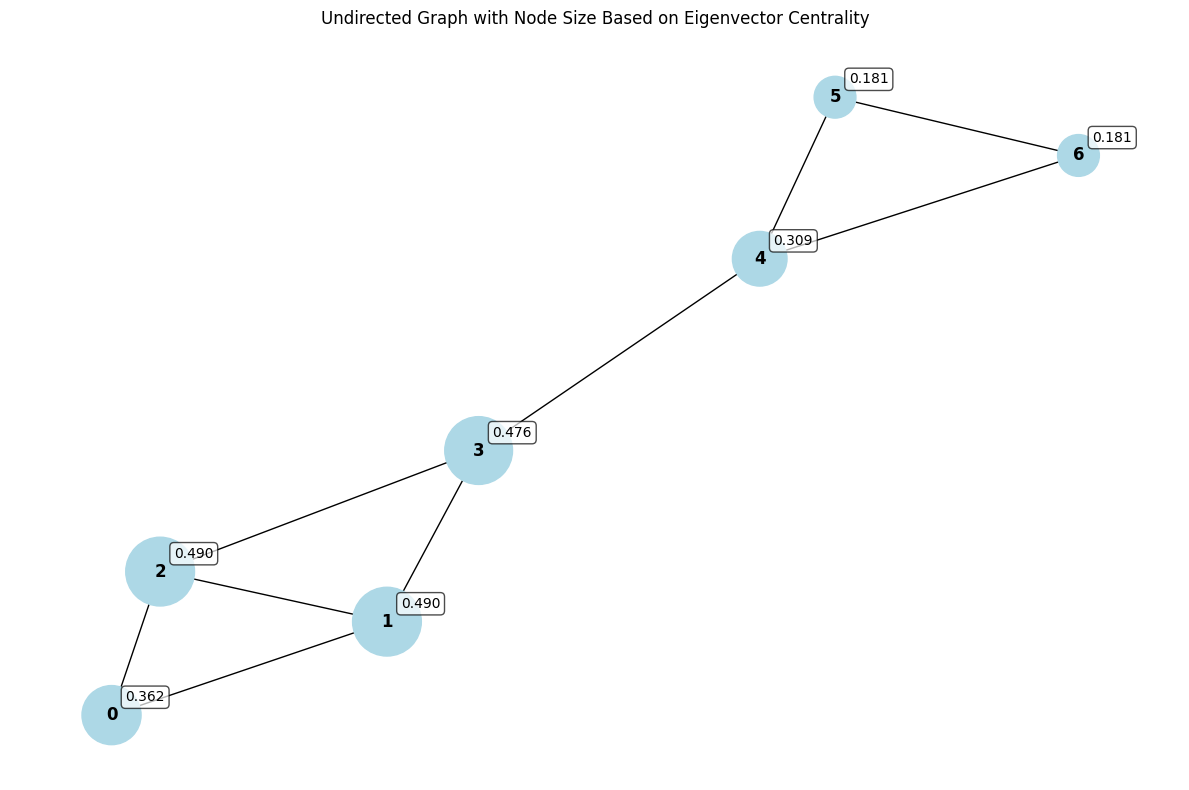

In [4]:
# Visualize the graph with node sizes based on centrality
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_undirected, seed=42)

# Create node sizes based on centrality (scaled for better visualization)
node_sizes = [nx_centrality[i] * 5000 for i in range(len(G_undirected))]

# Draw nodes with variable sizes
nx.draw_networkx_nodes(G_undirected, pos, node_color='lightblue',
                      node_size=node_sizes)

# Draw edges
nx.draw_networkx_edges(G_undirected, pos)

# Draw labels
nx.draw_networkx_labels(G_undirected, pos, font_weight='bold')

# Add a legend-like annotation showing centrality values
for i, (node, centrality) in enumerate(nx_centrality.items()):
    plt.annotate(f"{centrality:.3f}", 
                 xy=pos[node], xytext=(10, 10), 
                 textcoords="offset points",
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))

plt.title("Undirected Graph with Node Size Based on Eigenvector Centrality")
plt.axis('off')
plt.tight_layout()
plt.show()

## 4. The Problem with Directed Acyclic Graphs (DAGs)

### What is a DAG?

In a Directed Acyclic Graph (DAG):
- Nodes form a hierarchy with source nodes (no incoming edges) at the top
- Sink nodes (no outgoing edges) are at the bottom
- There are **no cycles** - you can never follow a path that returns to a node

### Common Examples of DAGs:

- **Dependency graphs** (software packages, task scheduling)
- **Citation networks** (academic papers)
- **Project task networks** (PERT/CPM)
- **Bayesian networks** (probabilistic graphical models)

### The Eigenvector Centrality Problem:

**Key problem**: Eigenvector centrality often fails in DAGs, resulting in all zeros.

**Why?** In the recursive definition, a node's centrality depends on the centrality of nodes pointing to it. Source nodes (with no incoming edges) get assigned zero centrality, and this propagates through the network.

**Mathematical explanation**: For a DAG, the adjacency matrix can be reordered into a strictly upper triangular matrix, which has all eigenvalues equal to zero.

Is this graph a DAG? True
Topological ordering: [0, 1, 2, 3, 4, 5, 6]

Adjacency matrix of the DAG:
[[0 1 1 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]

Eigenvalues of the DAG adjacency matrix:
[0. 0. 0. 0. 0. 0. 0.]
Maximum eigenvalue magnitude: 0.000000


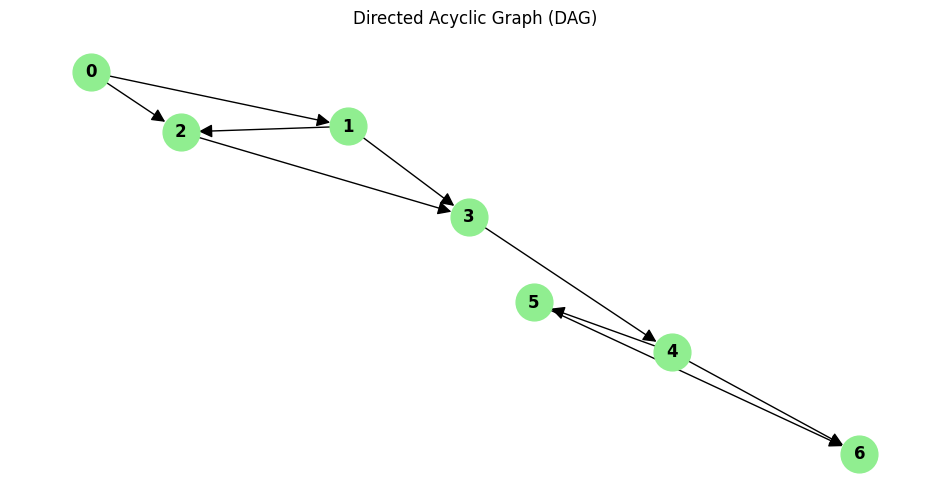

In [5]:
# Create a directed acyclic graph (DAG)
G_dag = nx.DiGraph()
G_dag.add_edges_from([
    (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (4, 6), (5, 6)
])

# Verify this is a DAG
print(f"Is this graph a DAG? {nx.is_directed_acyclic_graph(G_dag)}")

# Get the topological sort (shows the hierarchical ordering)
topo_sort = list(nx.topological_sort(G_dag))
print(f"Topological ordering: {topo_sort}")

# Convert to adjacency matrix
A_dag = nx.adjacency_matrix(G_dag).toarray()

print("\nAdjacency matrix of the DAG:")
print(A_dag)

# Calculate eigenvalues to demonstrate they're all zero
eigenvalues = np.linalg.eigvals(A_dag)
print("\nEigenvalues of the DAG adjacency matrix:")
print(eigenvalues)
print(f"Maximum eigenvalue magnitude: {max(abs(eigenvalues)):.6f}")

# Visualize the DAG
plt.figure(figsize=(12, 6))
pos = nx.draw_networkx(G_dag, arrows=True, arrowsize=20,
                      node_color='lightgreen', node_size=700,
                      font_weight='bold')
plt.title("Directed Acyclic Graph (DAG)")
plt.axis('off')
plt.show()

## 5. Step-by-step Analysis of Eigenvector Centrality Failure in DAGs

Let's examine exactly why eigenvector centrality becomes zero in a DAG by tracing through the power iteration method step by step. This visualization of the algorithm execution will help us understand the "cascade of zeros" phenomenon.

Source nodes (no incoming edges): [0]
Sink nodes (no outgoing edges): [6]

Adjacency matrix of the DAG:
[[0 1 1 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]

Initial centrality vector: [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]

After iteration 1:
Unnormalized: [0.28571429 0.28571429 0.14285714 0.14285714 0.28571429 0.14285714
 0.        ]
Normalized: [0.51639778 0.51639778 0.25819889 0.25819889 0.51639778 0.25819889
 0.        ]

After iteration 2:
Unnormalized: [0.77459667 0.51639778 0.25819889 0.51639778 0.25819889 0.
 0.        ]
Normalized: [0.6882472  0.45883147 0.22941573 0.45883147 0.22941573 0.
 0.        ]

After iteration 3:
Unnormalized: [0.6882472  0.6882472  0.45883147 0.22941573 0.         0.
 0.        ]
Normalized: [0.62554324 0.62554324 0.41702883 0.20851441 0.         0.
 0.        ]

After iteration 4:
Unnormalized: [1.04257207 0.62554324 0.20851441 0.         0. 

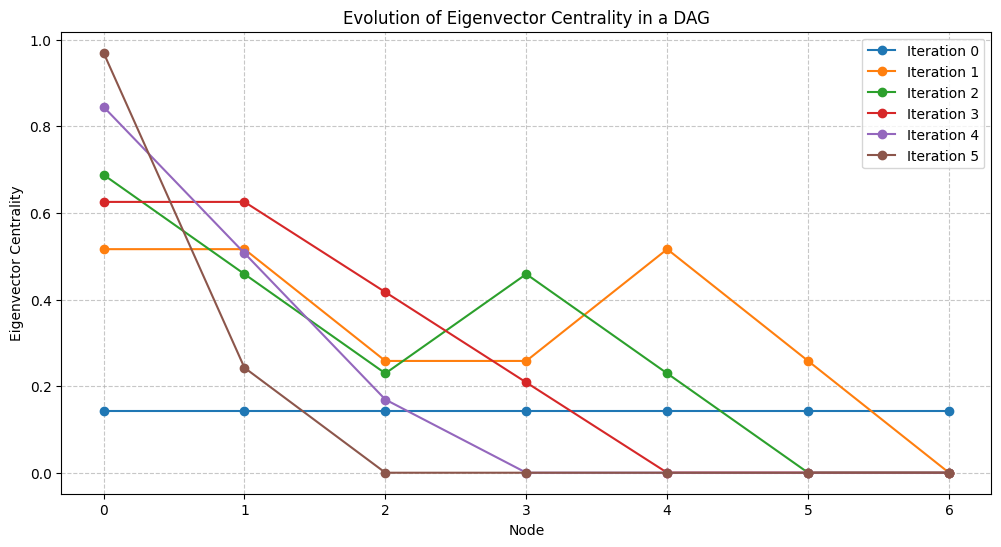

In [6]:
# Identify source and sink nodes
source_nodes = [n for n in G_dag.nodes() if G_dag.in_degree(n) == 0]
sink_nodes = [n for n in G_dag.nodes() if G_dag.out_degree(n) == 0]
print(f"Source nodes (no incoming edges): {source_nodes}")
print(f"Sink nodes (no outgoing edges): {sink_nodes}")

# Show the adjacency matrix
print("\nAdjacency matrix of the DAG:")
print(A_dag)

# Demonstrate the power iteration method step by step
x = np.ones(len(G_dag)) / len(G_dag)  # Initial uniform vector
print("\nInitial centrality vector:", x)

# Track the evolution of centrality over multiple iterations
iterations = 5
centrality_history = [x.copy()]

for i in range(iterations):
    x = A_dag @ x  # Matrix multiplication
    print(f"\nAfter iteration {i+1}:")
    print(f"Unnormalized: {x}")
    
    # Calculate norm for normalization
    norm = np.linalg.norm(x)
    if norm > 0:  # Only normalize if norm is non-zero
        x = x / norm
        print(f"Normalized: {x}")
        centrality_history.append(x.copy())
    else:
        print("Vector has zero norm - all centralities are zero!")
        break

# Visualize how the centrality evolves
plt.figure(figsize=(12, 6))
for i, centrality in enumerate(centrality_history):
    plt.plot(range(len(G_dag)), centrality, marker='o', label=f"Iteration {i}")
    
plt.xlabel("Node")
plt.ylabel("Eigenvector Centrality")
plt.title("Evolution of Eigenvector Centrality in a DAG")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## 6. Understanding the Zero-Centrality Phenomenon

We can see how zeros propagate through the network with each iteration:

### Mechanism of Failure:

1. **First step**: Source nodes (with no incoming edges) immediately get a centrality of 0
2. **Next steps**: Nodes that only receive connections from nodes with zero centrality also get zero centrality
3. **Final result**: Eventually, all nodes end up with zero centrality

### Mathematical Explanation:

- The eigenvector centrality equation $\lambda x = Ax$ means each node's centrality is a weighted sum of its **incoming** neighbors
- In a DAG, source nodes have no incoming neighbors, so their centrality becomes zero
- This propagates down the network in a "cascade of zeros"
- The adjacency matrix of a DAG can be reordered to be upper triangular, which has all eigenvalues equal to zero
- With the largest eigenvalue being zero, the eigenvector centrality isn't well-defined

### Practical Implications:

This isn't just a mathematical curiosity - it means we can't use standard eigenvector centrality to meaningfully analyze many important real-world networks that are naturally directed and acyclic, like citation networks, dependency graphs, or hierarchical organizational structures.

In [7]:
# Compute eigenvector centrality for the DAG
our_centrality_dag = compute_eigenvector_centrality(A_dag)

# Print the results
print("\nEigenvector centrality for the DAG:")
for i, c in enumerate(our_centrality_dag):
    print(f"Node {i}: {c:.6f}")


Eigenvector centrality for the DAG:
Node 0: 0.000000
Node 1: 0.000000
Node 2: 0.000000
Node 3: 0.000000
Node 4: 0.000000
Node 5: 0.000000
Node 6: 0.000000


In [8]:
# Try using NetworkX's implementation
try:
    nx_centrality_dag = nx.eigenvector_centrality(G_dag)
    print("\nNetworkX implementation for DAG:")
    for i in range(len(G_dag)):
        print(f"Node {i}: {nx_centrality_dag[i]:.6f}")
except Exception as e:
    print("\nNetworkX implementation failed for the DAG with error:")
    print(str(e))
    print("This is expected behavior for DAGs!")


NetworkX implementation failed for the DAG with error:
(PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')
This is expected behavior for DAGs!


## 7. Conclusion: When to Use Eigenvector Centrality

### Best for:
- **Undirected networks**: Social networks, collaboration networks
- **Directed networks with cycles**: Web graphs, communication patterns
- **Identifying influential nodes** in networks where influence flows bidirectionally or in cycles

### Not suitable for:
- **Directed acyclic graphs (DAGs)**: Citation networks, hierarchies, dependency trees
- **Networks with many source nodes**: These will get zero centrality

### Key takeaways:
1. Eigenvector centrality measures importance based on connection to important nodes
2. It works via a recursive definition, solvable through power iteration
3. In DAGs, the recursion leads to zero centrality for all nodes
4. For DAGs, use alternatives like Katz centrality, PageRank, or betweenness centrality

### Further Learning Resources:

- Newman, M. E. J. (2010). Networks: An Introduction. Oxford University Press.
- Kolaczyk, E. D. (2009). Statistical Analysis of Network Data. Springer.
- [NetworkX Documentation on Centrality Measures](https://networkx.org/documentation/stable/reference/algorithms/centrality.html)

By understanding these properties, you can choose the appropriate centrality measure for your specific network analysis tasks.